# **Overview**

In this notebook, we perform Market Basket Analysis (MBA) to uncover product association rules and co-purchase patterns in the Olist e-commerce dataset.

Market Basket Analysis is a data mining technique that identifies relationships between items purchased together. By applying it to the Olist dataset, we can better understand customer purchasing behavior and discover actionable insights for cross-selling and marketing strategies.

### **Objectives**

Through this analysis, we aim to answer key business questions such as:

* Which products are frequently bought together?
* What product combinations should Olist recommend for cross-selling?
* Which product bundles can drive promotions or increase sales value?

In [54]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine




In [55]:
# Define connection string for SQLAlchemy
conn_str = (
    "mssql+pyodbc://localhost\\MSSQLSERVER01/olist_dwh?"
    "driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

# Create SQLAlchemy engine
engine = create_engine(conn_str)

# Query your database
query = """
SELECT Product_SK, product_name, product_category_name, order_id
FROM fact_sales INNER JOIN dim_products ON Product_FK = Product_SK
"""

df = pd.read_sql(query, engine)

In [56]:
df.head()

,Product_SK,product_name,product_category_name,order_id
0,1,Dior Cologne Gold,Perfumery,f30149f4a8882a08895b6a242aa0d612
1,2,Meguiar's Spark Plug 619,Auto,f5eda0ded77c1293b04c953138c8331d
2,3,AmazonBasics Sheet Set Ultra V1,Bed Bath Table,0bf736fd0fd5169d60de3699fcbcf986
3,4,Corningware Grater Series 10 V2,Housewares,3aba44d8e554ab4bb8c09f6f78032ca8
4,4,Corningware Grater Series 10 V2,Housewares,6f0dfb5b5398b271cc6bbd9ee263530e


In [57]:
df.shape

(112650, 4)

In [58]:
# Count products per order
order_counts = df.groupby('order_id')['Product_SK'].nunique()

print("Percentage of Orders that have only 1 item: ", (order_counts == 1).mean())

Percentage of Orders that have only 1 item:  0.9672024810978452


Filter orders with multiple items to focus on transactions that can reveal meaningful product associations.
Orders that contain only a single product cannot contribute to association rule discovery, since association rules require at least two items to establish a relationship. Therefore, we remove all orders with only one item from the dataset. This ensures that the Apriori algorithm analyzes transactions where co-occurrence patterns can actually exist.

In [59]:
# Keep only orders with more than one product
multi_item_orders = order_counts[order_counts > 1].index
df_filtered = df[df['order_id'].isin(multi_item_orders)]
df_filtered.shape


(7768, 4)

In [60]:
df_filtered.Product_SK.nunique()

4885

In [61]:

# Count products by order_id, then pivot so product names become columns
basket = (
    df_filtered.groupby(['order_id', 'product_name'])['product_name']
    .count().unstack().fillna(0)
)

# Convert counts to 1 (purchased) or 0 (not purchased)
basket[basket > 0] = 1

# Convert the basket to boolean type for Apriori
basket = basket.astype(bool)

basket

product_name,1-800-Flowers Mixed Flowers 796,3M Air Filter 274 V2,3M Air Filter Mini,3M Battery Black V1,3M Battery Generation 9,3M Battery Gray,3M Battery Max,3M Battery Series 4,3M Brake Pad 632,3M Brake Pad Lite,...,Zebra Pen Set Gray,Zebra Pencil Case Max V2,Zebra Planner 2024,Zebra Planner Blue,Zebra Planner Generation 2,Zinus Bed Frame 2024,Zinus Headboard Blue,eBay Handmade Product 363,eBay Resale Item,eBay Second-Hand Collection 2
order_id,,,,,,,,,,,,,,,,,,,,,
002f98c0f7efd42638ed6100ca699b42,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
00337fe25a3780b3424d9ad7c5a4b35e,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
005d9a5423d47281ac463a968b3936fb,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
00946f674d880be1f188abc10ad7cf46,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0097f0545a302aafa32782f1734ff71c,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb18bf111fa70edf316eb0390427986,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ffb8f7de8940249a3221252818937ecb,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ffb9a9cd00c74c11c24aa30b3d78e03b,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [62]:
0.001 * basket.shape[0]

3.236

In [63]:
basket.shape

(3236, 4885)

In [64]:
frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.001236,(3M Laminator 470)
1,0.001545,(AmazonBasics Blanket Collection 2 V2)
2,0.001545,(AmazonBasics Blanket V3)
3,0.001236,(AmazonBasics Hand Towel Mini)
4,0.001545,(AmazonBasics Pillow V3)
...,...,...
221,0.001545,"(PlayStation Controller, Sony Memory Card)"
222,0.001236,"(Pottery Barn Bath Towel 606, Ralph Lauren Han..."
223,0.001854,"(Target Bath Towel Rose Gold V1, Ralph Lauren ..."
224,0.001854,"(Wayfair Table Runner Mini, Target Sheet Set 357)"


In [65]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

In [66]:
rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Corsair Wireless Mouse 645),(Anker Mouse Pad Generation 8),0.001236,0.001854,0.001236,1.000000,539.333333,1.0,0.001234,inf,0.999381,0.666667,1.000000,0.833333
4,(Anker Mouse Pad Generation 8),(Corsair Wireless Mouse 645),0.001854,0.001236,0.001236,0.666667,539.333333,1.0,0.001234,2.996292,1.000000,0.666667,0.666254,0.833333
7,(BenQ USB Hub Navy V1),(Logitech Wireless Mouse 351),0.001854,0.001854,0.001854,1.000000,539.333333,1.0,0.001851,inf,1.000000,1.000000,1.000000,1.000000
8,(Logitech Wireless Mouse 351),(BenQ USB Hub Navy V1),0.001854,0.001854,0.001854,1.000000,539.333333,1.0,0.001851,inf,1.000000,1.000000,1.000000,1.000000
29,(HP Laptop Stand 2024 V2),(HP Docking Station V3),0.001854,0.001854,0.001854,1.000000,539.333333,1.0,0.001851,inf,1.000000,1.000000,1.000000,1.000000
28,(HP Docking Station V3),(HP Laptop Stand 2024 V2),0.001854,0.001854,0.001854,1.000000,539.333333,1.0,0.001851,inf,1.000000,1.000000,1.000000,1.000000
19,(Corsair Mouse Pad 184),(Microsoft Mouse Pad Plus),0.002163,0.001854,0.001854,0.857143,462.285714,1.0,0.001850,6.987021,1.000000,0.857143,0.856877,0.928571
5,(BenQ Docking Station V5),(BenQ Laptop Stand V2),0.001854,0.002163,0.001854,1.000000,462.285714,1.0,0.001850,inf,0.999690,0.857143,1.000000,0.928571
6,(BenQ Laptop Stand V2),(BenQ Docking Station V5),0.002163,0.001854,0.001854,0.857143,462.285714,1.0,0.001850,6.987021,1.000000,0.857143,0.856877,0.928571
23,(Razer Mechanical Keyboard Black V2),(Corsair Wireless Mouse 2023),0.002163,0.002163,0.002163,1.000000,462.285714,1.0,0.002158,inf,1.000000,1.000000,1.000000,1.000000


In [67]:
rules.shape

(39, 14)

In [68]:

# Create a new column with clean text
rules['rule'] = rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " → " + \
                    rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Optional: reorder columns for readability
rules = rules[['rule', 'antecedents', 'consequents', 'antecedent support', 'consequent support', 'support',
                       'confidence', 'lift']]


In [69]:
top_rules = rules.sort_values('confidence', ascending=False).head(10)


In [70]:
top_rules

,rule,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,IKEA Duvet Cover 955 → AmazonBasics Table Runn...,(IKEA Duvet Cover 955),(AmazonBasics Table Runner 918),0.001236,0.002781,0.001236,1.0,359.555556
18,Castrol Headlight Bulb 2024 V3 → Castrol Motor...,(Castrol Headlight Bulb 2024 V3),(Castrol Motor Oil Collection 3),0.001854,0.003090,0.001854,1.0,323.600000
3,Corsair Wireless Mouse 645 → Anker Mouse Pad G...,(Corsair Wireless Mouse 645),(Anker Mouse Pad Generation 8),0.001236,0.001854,0.001236,1.0,539.333333
5,BenQ Docking Station V5 → BenQ Laptop Stand V2,(BenQ Docking Station V5),(BenQ Laptop Stand V2),0.001854,0.002163,0.001854,1.0,462.285714
29,HP Laptop Stand 2024 V2 → HP Docking Station V3,(HP Laptop Stand 2024 V2),(HP Docking Station V3),0.001854,0.001854,0.001854,1.0,539.333333
7,BenQ USB Hub Navy V1 → Logitech Wireless Mouse...,(BenQ USB Hub Navy V1),(Logitech Wireless Mouse 351),0.001854,0.001854,0.001854,1.0,539.333333
8,Logitech Wireless Mouse 351 → BenQ USB Hub Nav...,(Logitech Wireless Mouse 351),(BenQ USB Hub Navy V1),0.001854,0.001854,0.001854,1.0,539.333333
28,HP Docking Station V3 → HP Laptop Stand 2024 V2,(HP Docking Station V3),(HP Laptop Stand 2024 V2),0.001854,0.001854,0.001854,1.0,539.333333
23,Razer Mechanical Keyboard Black V2 → Corsair W...,(Razer Mechanical Keyboard Black V2),(Corsair Wireless Mouse 2023),0.002163,0.002163,0.002163,1.0,462.285714
22,Corsair Wireless Mouse 2023 → Razer Mechanical...,(Corsair Wireless Mouse 2023),(Razer Mechanical Keyboard Black V2),0.002163,0.002163,0.002163,1.0,462.285714


Text(0.5, 1.0, 'Rule by Confidence')

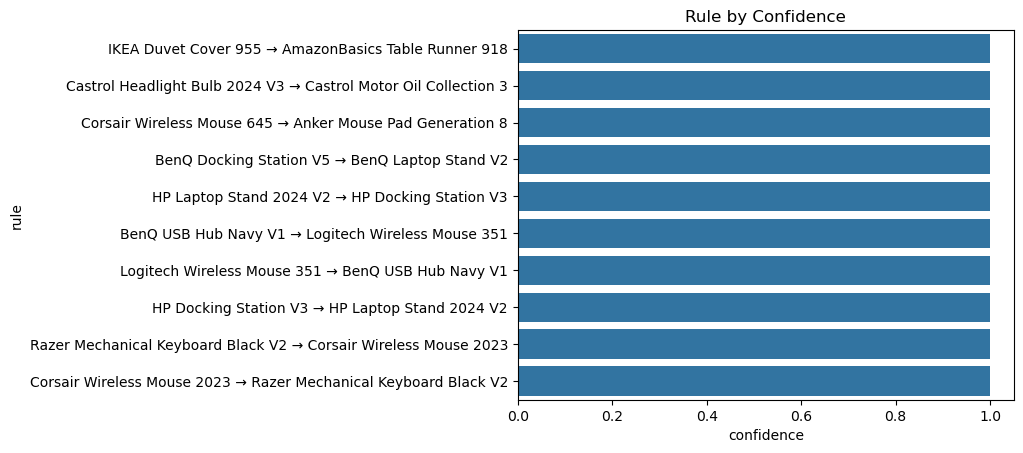

In [71]:
sns.barplot(data=top_rules, x='confidence', y='rule')
plt.title('Rule by Confidence')

In [72]:
top_rules.to_csv('olist_mba_top_rules.csv', index=False)

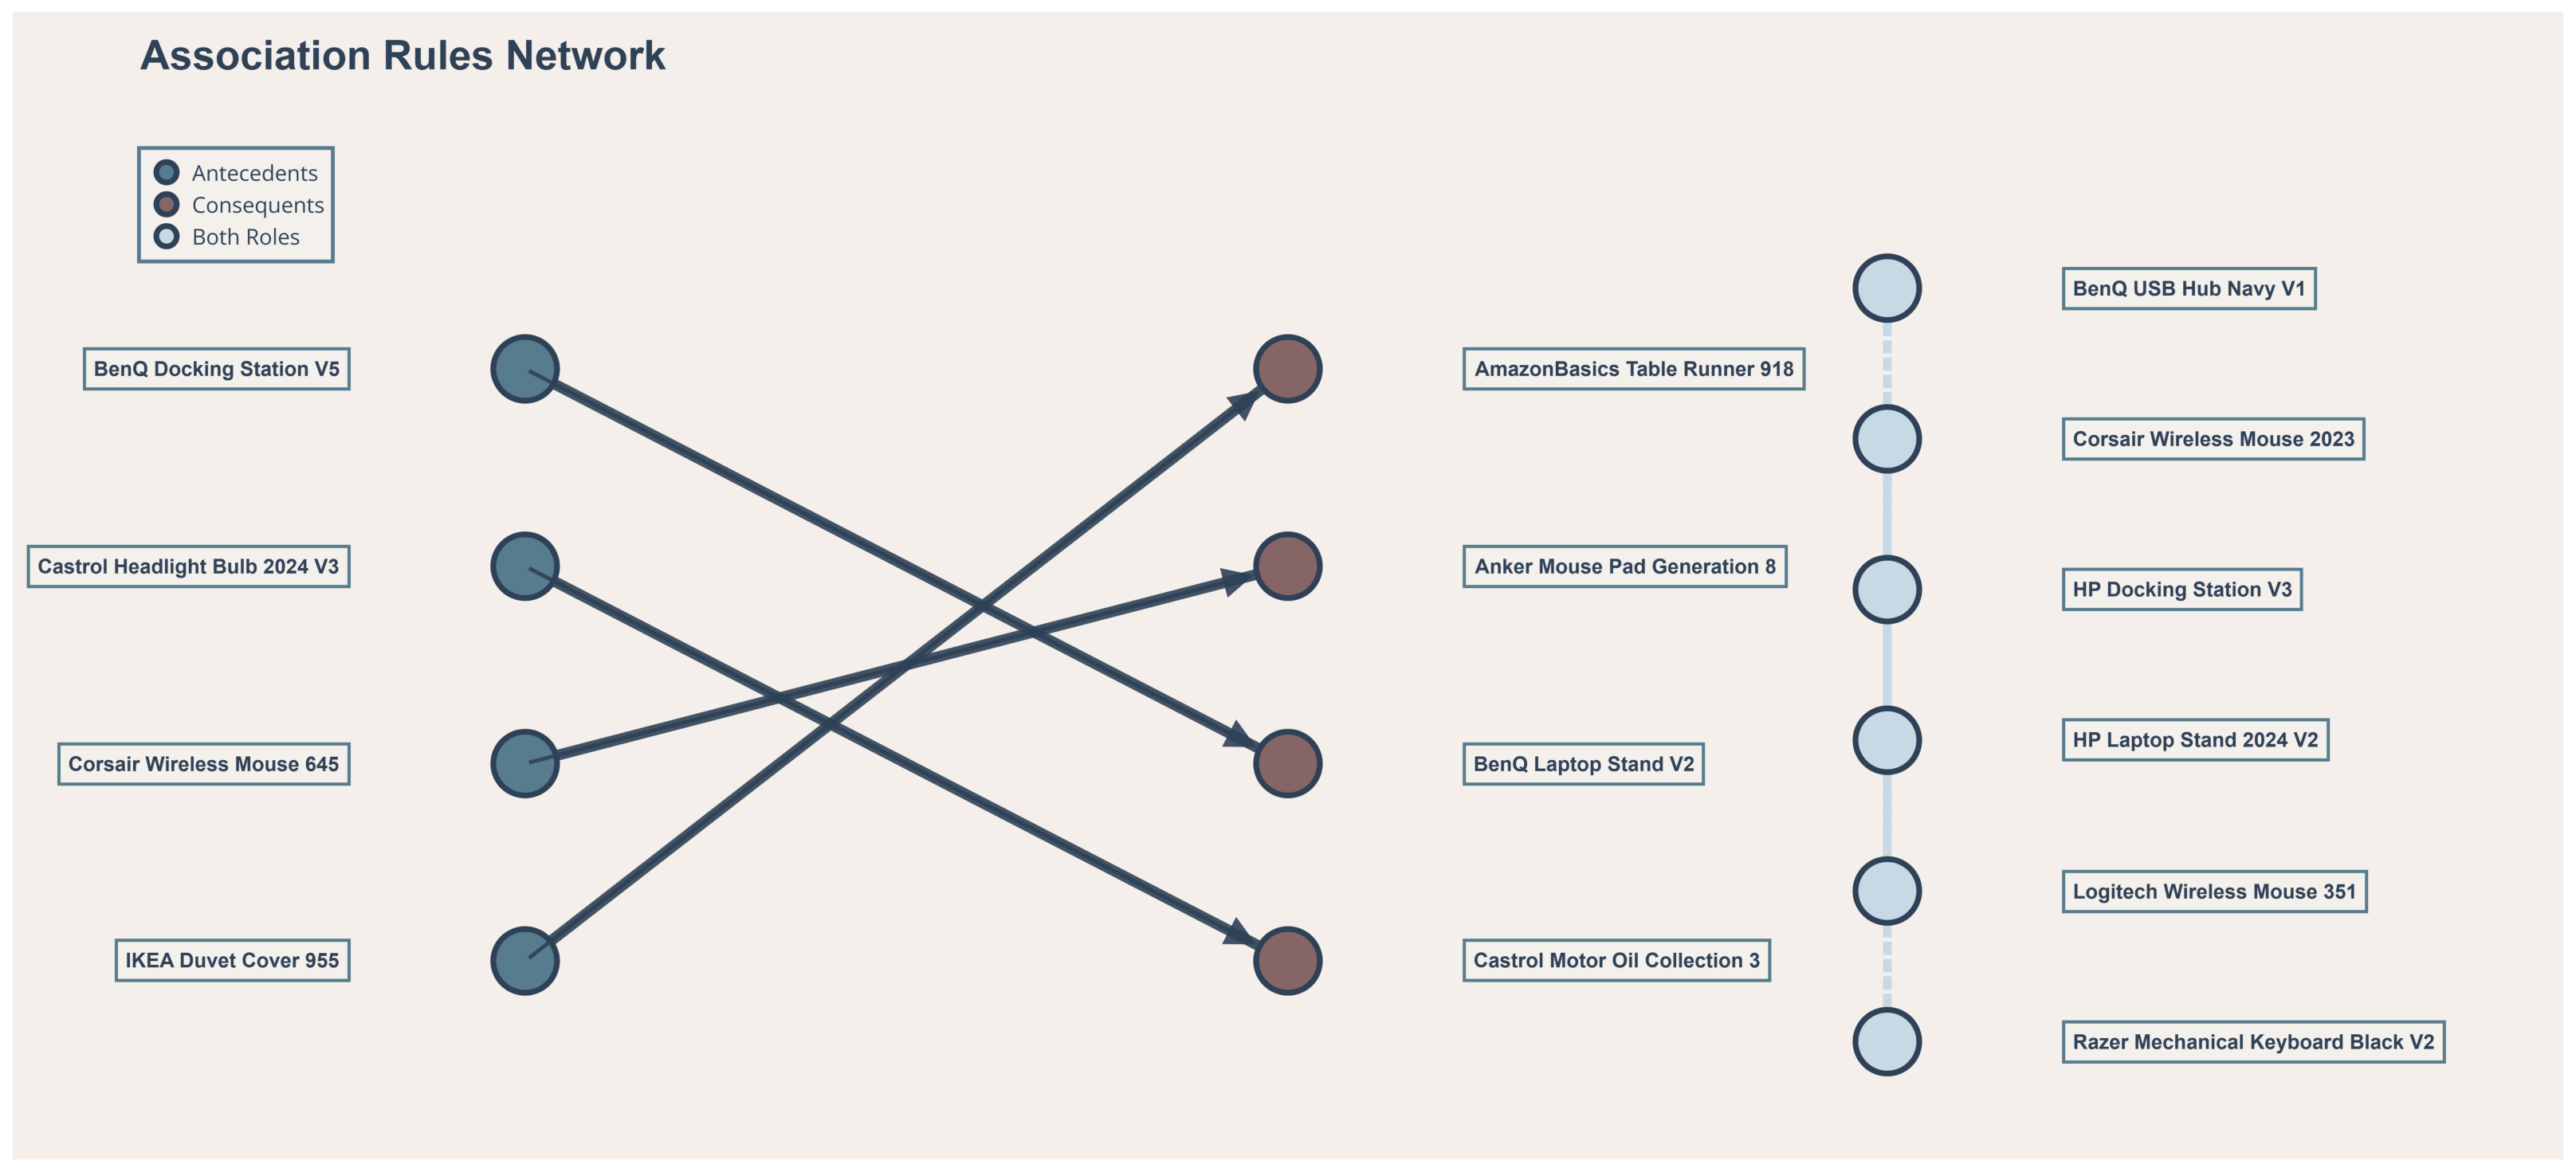

In [73]:
# The following code to create a dataframe and remove duplicated rows is always executed and acts as a preamble for your script: 

# dataset = pandas.DataFrame(antecedents, consequents, antecedent support, consequent support, support, confidence, lift)
# dataset = dataset.drop_duplicates()

# Paste or type your script code here:
import plotly.graph_objects as go
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# Create directed graph from Power BI data
G = nx.DiGraph()

for idx, row in top_rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], 
               weight=row['confidence'], lift=row['lift'])

# Helper function to format frozenset to readable string
def format_item_name(item):
    if isinstance(item, frozenset):
        items = sorted(list(item))
        result = ', '.join(str(i) for i in items)
        return result[:50] + '...' if len(result) > 50 else result
    elif isinstance(item, (list, tuple, set)):
        items = sorted(list(item))
        result = ', '.join(str(i) for i in items)
        return result[:50] + '...' if len(result) > 50 else result
    else:
        item_str = str(item)
        item_str = item_str.replace("frozenset({", "").replace("})", "")
        item_str = item_str.replace("frozenset(", "").replace(")", "")
        item_str = item_str.replace("{", "").replace("}", "")
        item_str = item_str.replace("'", "").replace('"', "")
        return item_str[:50] + '...' if len(item_str) > 50 else item_str

# Identify antecedents and consequents based on their roles
antecedents_nodes = set()
consequents_nodes = set()
node_roles = {}

for node in G.nodes():
    out_degree = G.out_degree(node)
    in_degree = G.in_degree(node)
    
    if out_degree > in_degree:
        antecedents_nodes.add(node)
        node_roles[node] = 'antecedent'
    elif in_degree > out_degree:
        consequents_nodes.add(node)
        node_roles[node] = 'consequent'
    else:
        node_roles[node] = 'both'

antecedent_list = sorted(list(antecedents_nodes), key=lambda x: format_item_name(x))
consequent_list = sorted(list(consequents_nodes), key=lambda x: format_item_name(x))
both_list = sorted([node for node in G.nodes() if node_roles[node] == 'both'], key=lambda x: format_item_name(x))

pos = {}

# Left column: Antecedents
for i, node in enumerate(antecedent_list):
    y_spacing = 2.2 / max(len(antecedent_list) - 1, 1) if len(antecedent_list) > 1 else 0
    pos[node] = (-0.4, 1.1 - i * y_spacing)

# Middle column: Consequents
for i, node in enumerate(consequent_list):
    y_spacing = 2.2 / max(len(consequent_list) - 1, 1) if len(consequent_list) > 1 else 0
    pos[node] = (0.3, 1.1 - i * y_spacing)

# Right column: Both roles
for i, node in enumerate(both_list):
    y_spacing = 2.8 / max(len(both_list) - 1, 1) if len(both_list) > 1 else 0
    pos[node] = (0.85, 1.4 - i * y_spacing)

edge_traces = []
annotations = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    confidence = edge[2]['weight']
    lift = edge[2]['lift']
    
    opacity = 0.45 + (confidence * 0.45)
    width = 3.5 + (confidence * 5)
    
    # Check if edge involves "Both Roles" node
    is_both_connection = (edge[0] in both_list or edge[1] in both_list)
    
    edge_traces.append(go.Scatter(
        x=[x0, x1],
        y=[y0, y1],
        mode='lines',
        line=dict(
            width=width if not is_both_connection else width * 0.8,
            color=f'rgba(47, 65, 87, {opacity})' if not is_both_connection else f'rgba(199, 217, 229, {opacity + 0.2})',
            dash='solid' if not is_both_connection else 'dot'
        ),
        hovertemplate=f"<b style='font-size:16px'>{format_item_name(edge[0])} ↔ {format_item_name(edge[1])}</b><br>" +
                     f"<span style='font-size:14px'>Confidence: {confidence:.3f}<br>Lift: {lift:.3f}</span><extra></extra>",
        showlegend=False
    ))
    
    # Only add arrows for antecedent → consequent connections - SLIGHTLY LARGER
    if not is_both_connection:
        annotations.append(dict(
            x=x1, y=y1, ax=x0, ay=y0,
            xref='x', yref='y', axref='x', ayref='y',
            showarrow=True, 
            arrowhead=2, 
            arrowsize=1.6,  # INCREASED from 1.2 to 1.6
            arrowwidth=3,  # INCREASED from 2.5 to 3
            arrowcolor=f'rgba(47, 65, 87, {opacity})',
            standoff=28
        ))

node_traces = []

# Antecedent nodes (Air Force Blue)
if antecedent_list:
    ant_x = [pos[node][0] for node in antecedent_list]
    ant_y = [pos[node][1] for node in antecedent_list]
    ant_hover = [f"<b style='font-size:16px'>{format_item_name(node)}</b><br>" +
                 f"<span style='font-size:14px'>Type: Antecedent<br>" +
                 f"Outgoing: {G.out_degree(node)}<br>Incoming: {G.in_degree(node)}</span>"
                 for node in antecedent_list]
    
    node_traces.append(go.Scatter(
        x=ant_x, y=ant_y, mode='markers',
        marker=dict(size=50, color='#577C8E', line=dict(color='#2F4157', width=4.5)),
        hovertext=ant_hover, hoverinfo='text',
        showlegend=True, name='Antecedents'
    ))

# Consequent nodes (Rose Taupe)
if consequent_list:
    cons_x = [pos[node][0] for node in consequent_list]
    cons_y = [pos[node][1] for node in consequent_list]
    cons_hover = [f"<b style='font-size:16px'>{format_item_name(node)}</b><br>" +
                  f"<span style='font-size:14px'>Type: Consequent<br>" +
                  f"Outgoing: {G.out_degree(node)}<br>Incoming: {G.in_degree(node)}</span>"
                  for node in consequent_list]
    
    node_traces.append(go.Scatter(
        x=cons_x, y=cons_y, mode='markers',
        marker=dict(size=50, color='#856566', line=dict(color='#2F4157', width=4.5)),
        hovertext=cons_hover, hoverinfo='text',
        showlegend=True, name='Consequents'
    ))

# Both role nodes (Columbia Blue)
if both_list:
    both_x = [pos[node][0] for node in both_list]
    both_y = [pos[node][1] for node in both_list]
    both_hover = [f"<b style='font-size:16px'>{format_item_name(node)}</b><br>" +
                  f"<span style='font-size:14px'>Type: Both Roles<br>" +
                  f"Outgoing: {G.out_degree(node)}<br>Incoming: {G.in_degree(node)}</span>"
                  for node in both_list]
    
    node_traces.append(go.Scatter(
        x=both_x, y=both_y, mode='markers',
        marker=dict(size=50, color='#C7D9E5', line=dict(color='#2F4157', width=4.5)),
        hovertext=both_hover, hoverinfo='text',
        showlegend=True, name='Both Roles'
    ))

# Add text annotations for node labels
for node in G.nodes():
    x, y = pos[node]
    label = format_item_name(node)
    
    if node in antecedents_nodes:
        x_offset = -0.16
        xanchor = 'right'
        y_label = y
    elif node in consequents_nodes:
        x_offset = 0.16
        xanchor = 'left'
        y_label = y
    else:
        x_offset = 0.16
        xanchor = 'left'
        y_label = y
    
    annotations.append(dict(
        x=x + x_offset, y=y_label, text=f"<b>{label}</b>", showarrow=False,
        font=dict(size=16, color='#2F4157', family='Arial, sans-serif'),
        bgcolor='rgba(244, 239, 235, 0.96)',
        bordercolor='#577C8E', borderwidth=2.5, borderpad=6,
        xanchor=xanchor, yanchor='middle'
    ))

fig = go.Figure(data=edge_traces + node_traces)

# Dynamic height
max_nodes = max(len(antecedent_list), len(consequent_list), len(both_list))
dynamic_height = max(900, min(1600, max_nodes * 110))

fig.update_layout(
    title={
        'text': '<b>Association Rules Network</b>',
        'font': {'size': 32, 'color': '#2F4157', 'family': 'Arial, sans-serif'}
    },
    showlegend=True,
    legend=dict(
        x=0.02, y=0.98,
        bgcolor='rgba(244, 239, 235, 0.96)',
        bordercolor='#577C8E',
        borderwidth=3,
        font=dict(size=17, color='#2F4157')
    ),
    hovermode='closest',
    margin=dict(t=90, b=50, l=60, r=60),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-0.8, 1.4]),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-1.6, 2.0]),
    plot_bgcolor='#F4EFEB',
    paper_bgcolor='#F4EFEB',
    annotations=annotations,
    height=dynamic_height
)

# Convert to high-resolution image
img_bytes = fig.to_image(format="png", width=2000, height=dynamic_height, scale=4)
img = Image.open(BytesIO(img_bytes))

plt.figure(figsize=(20, dynamic_height/100), dpi=160)
plt.imshow(img)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [74]:
top_rules

,rule,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,IKEA Duvet Cover 955 → AmazonBasics Table Runn...,(IKEA Duvet Cover 955),(AmazonBasics Table Runner 918),0.001236,0.002781,0.001236,1.0,359.555556
18,Castrol Headlight Bulb 2024 V3 → Castrol Motor...,(Castrol Headlight Bulb 2024 V3),(Castrol Motor Oil Collection 3),0.001854,0.003090,0.001854,1.0,323.600000
3,Corsair Wireless Mouse 645 → Anker Mouse Pad G...,(Corsair Wireless Mouse 645),(Anker Mouse Pad Generation 8),0.001236,0.001854,0.001236,1.0,539.333333
5,BenQ Docking Station V5 → BenQ Laptop Stand V2,(BenQ Docking Station V5),(BenQ Laptop Stand V2),0.001854,0.002163,0.001854,1.0,462.285714
29,HP Laptop Stand 2024 V2 → HP Docking Station V3,(HP Laptop Stand 2024 V2),(HP Docking Station V3),0.001854,0.001854,0.001854,1.0,539.333333
7,BenQ USB Hub Navy V1 → Logitech Wireless Mouse...,(BenQ USB Hub Navy V1),(Logitech Wireless Mouse 351),0.001854,0.001854,0.001854,1.0,539.333333
8,Logitech Wireless Mouse 351 → BenQ USB Hub Nav...,(Logitech Wireless Mouse 351),(BenQ USB Hub Navy V1),0.001854,0.001854,0.001854,1.0,539.333333
28,HP Docking Station V3 → HP Laptop Stand 2024 V2,(HP Docking Station V3),(HP Laptop Stand 2024 V2),0.001854,0.001854,0.001854,1.0,539.333333
23,Razer Mechanical Keyboard Black V2 → Corsair W...,(Razer Mechanical Keyboard Black V2),(Corsair Wireless Mouse 2023),0.002163,0.002163,0.002163,1.0,462.285714
22,Corsair Wireless Mouse 2023 → Razer Mechanical...,(Corsair Wireless Mouse 2023),(Razer Mechanical Keyboard Black V2),0.002163,0.002163,0.002163,1.0,462.285714


In [75]:
rules

,rule,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,IKEA Duvet Cover 955 → AmazonBasics Table Runn...,(IKEA Duvet Cover 955),(AmazonBasics Table Runner 918),0.001236,0.002781,0.001236,1.000000,359.555556
1,BenQ Webcam Red → Anker Docking Station 160,(BenQ Webcam Red),(Anker Docking Station 160),0.001545,0.001854,0.001236,0.800000,431.466667
2,Anker Docking Station 160 → BenQ Webcam Red,(Anker Docking Station 160),(BenQ Webcam Red),0.001854,0.001545,0.001236,0.666667,431.466667
3,Corsair Wireless Mouse 645 → Anker Mouse Pad G...,(Corsair Wireless Mouse 645),(Anker Mouse Pad Generation 8),0.001236,0.001854,0.001236,1.000000,539.333333
4,Anker Mouse Pad Generation 8 → Corsair Wireles...,(Anker Mouse Pad Generation 8),(Corsair Wireless Mouse 645),0.001854,0.001236,0.001236,0.666667,539.333333
5,BenQ Docking Station V5 → BenQ Laptop Stand V2,(BenQ Docking Station V5),(BenQ Laptop Stand V2),0.001854,0.002163,0.001854,1.000000,462.285714
6,BenQ Laptop Stand V2 → BenQ Docking Station V5,(BenQ Laptop Stand V2),(BenQ Docking Station V5),0.002163,0.001854,0.001854,0.857143,462.285714
7,BenQ USB Hub Navy V1 → Logitech Wireless Mouse...,(BenQ USB Hub Navy V1),(Logitech Wireless Mouse 351),0.001854,0.001854,0.001854,1.000000,539.333333
8,Logitech Wireless Mouse 351 → BenQ USB Hub Nav...,(Logitech Wireless Mouse 351),(BenQ USB Hub Navy V1),0.001854,0.001854,0.001854,1.000000,539.333333
9,Meguiar's Air Filter 445 → Bosch Spark Plug Mo...,(Meguiar's Air Filter 445),(Bosch Spark Plug Model 6),0.002472,0.002472,0.001545,0.625000,252.812500


In [76]:
rules.to_csv('olist_mba_rules.csv', index=False, encoding='utf-8-sig')

# Conclusion

Approximately 97% of orders contain only a single item. To focus on transactions where meaningful product associations could arise, we filtered to the subset of orders with two or more items, leaving 3,236 transactions for association-rule mining.
Using a minimum support of 0.001 (≈ 3 orders in this dataset) and a minimum confidence threshold of 0.5, we uncovered ~60 rules. Some of these have confidence = 1, meaning that whenever the antecedent item(s) appear in an order, the consequent appears in 100% of such cases; and many show very high lift, indicating strong associations beyond random co-occurrence.

However, because the minimum support corresponds to only about three orders, we must treat these results as exploratory signals rather than fully robust insights.

The rules we found may hold business value (for example as cross-sell or bundling opportunities), and they are interesting given their high confidence and lift; but the extremely low absolute support means we should proceed with caution. We should consider collecting more data (or focusing on a higher support threshold) to increase reliability.

Therefore our conclusion is:
- We have uncovered valid and promising associations within the multi-item orders subset.
- The results should be considered useful leads, not definitive business rules.
- Next steps should include raising the support threshold (so rules are based on more transactions), validating the associations with business logic, and monitoring over time as more multi-item orders accumulate.